# Camera test file

## Import librarires

In [1]:
from picamera.array import PiYUVArray, PiRGBArray
from picamera import PiCamera

from scipy.signal import find_peaks, butter, filtfilt

import time
import matplotlib.pyplot as plt
import skimage as ski

## Camera resolution

In [2]:
res = (640, 480)

## Interface the camera capturing RGB images

#### If you get Error: "Out of Resources", then just release resources by running cell labled under "Release Resources"

In [3]:
camera = PiCamera()
        
# Check the link below for the combinations between mode and resolution
# https://picamera.readthedocs.io/en/release-1.13/fov.html#sensor-modes
camera.sensor_mode = 7
camera.resolution = res
camera.framerate = 30

# Initialize the buffer and start capturing
rawCapture = PiRGBArray(camera, size=res)
stream = camera.capture_continuous(rawCapture, format="rgb", use_video_port=True)

## Get next frame from the stream

In [12]:
i = 0

## Show the captured image

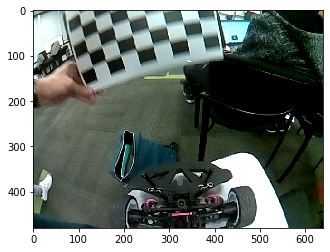

In [37]:
rawCapture.truncate(0)
frame = next(stream)

# Show photo
plt.imshow(frame.array)

# Save photo
plt.imsave(f"calib/{i}.png", frame.array)
i += 1

## Release Resources

In [6]:
stream.close()
rawCapture.close()
camera.close()

### The Following cells show that the larger image passed will tae longer run/process

In [7]:
print(frame.array)

None


In [8]:
%%timeit

# Bigger the image, more it takes for the conversion
I = ski.color.rgb2gray(frame.array)

AttributeError: 'NoneType' object has no attribute 'ndim'

In [9]:
%%timeit

# Algorithms operate faster on smaller images
I = ski.color.rgb2gray(frame.array[0:320, 0:240, :])

TypeError: 'NoneType' object is not subscriptable

In [10]:
# To filter the noise in the image we use a 3rd order Butterworth filter

# Wn = 0.02, the cut-off frequency, acceptable values are from 0 to 1
b, a = butter(3, 0.02)

In [35]:
# Run a track detection algorithm on a single horizontal line.
# Uses YUV420 image format as the Y component corresponds to image intensity (gray image)
# and thus there is no need to convert from RGB to BW

camera = PiCamera()
        
# Check the link below for the combinations between mode and resolution
# https://picamera.readthedocs.io/en/release-1.13/fov.html#sensor-modes
camera.sensor_mode = 7
camera.resolution = res
camera.framerate = 90

# Initialize the buffer and start capturing
rawCapture = PiYUVArray(camera, size=res)
stream = camera.capture_continuous(rawCapture, format="yuv", use_video_port=True)

# Measure the time needed to process 300 images to estimate the FPS
N = 1
k = 0
t = time.time()

for f in stream:
    # Get the intensity component of the image (a trick to get black and white images)
    I = f.array[:, :, 0]
    
    # Reset the buffer for the next image
    rawCapture.truncate(0)
    
    # Select a horizontal line in the middle of the image
    L = I[120, :]

    # Smooth the transitions so we can detect the peaks 
    Lf = filtfilt(b, a, L)

    # Find peaks which are higher than 0.5
    p = find_peaks(Lf, height=128)
    
    # Increment the number of processed frames
    k += 1
    if k > N:
        break
        
time_elapsed = time.time() - t
print("Elapsed {:0.2f} seconds, estimated FPS {:0.2f}".format(time_elapsed, N / time_elapsed))

# Release resources
stream.close()
rawCapture.close()
camera.close()

Elapsed 0.09 seconds, estimated FPS 11.01


In [36]:
# Run this section if you get the Error: Out of resources
camera.close()

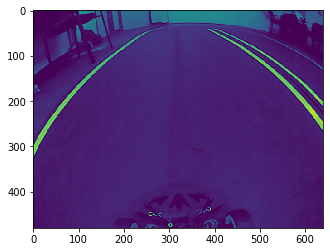

In [37]:
# Show the last image
plt.imshow(I)

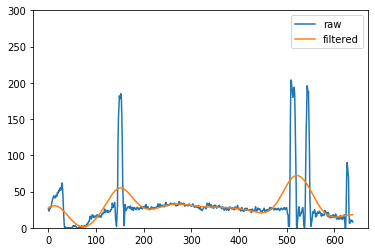

In [38]:
# Plot the pixel intensities along the selected line
plt.plot(L, label="raw")
plt.plot(Lf, label="filtered")
plt.ylim([0, 300])
plt.legend()

In [39]:
p

(array([], dtype=int32), {'peak_heights': array([], dtype=float64)})